### Settings & imports

In [1]:
%matplotlib notebook

In [2]:
import masserstein 

In [3]:
import os

from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns
from textwrap import wrap

from pathlib import Path

import pandas as pd

import time

In [4]:
nr_of_experiment = 7

In [5]:
if nr_of_experiment == 10:
    variant = 3

### Experiments data

In [6]:
components_dictionary = {'experiment_1': ['Pinene', 'Benzyl benzoate'],
                        'experiment_2': ['Pinene', 'Limonene'],
                        'experiment_7': ['Benzyl benzoate', 'm Anisaldehyde'],
                        'experiment_3': ['Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene'],
                        'experiment_6': ['Pinene', 'Benzyl benzoate'],
                        'experiment_5': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_9': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_4': ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'],
                        'experiment_8': ['Benzyl benzoate', 'm Anisaldehyde'],
                         'experiment_10': ['Leucine', 'Isoleucine', 'Valine'],
                        'experiment_11': ['Leucine', 'Isoleucine', 'Valine']}

In [7]:
protons_dictionary = {'experiment_1': [16, 12],
                        'experiment_2': [16, 16],
                        'experiment_7': [12, 8],
                        'experiment_3': [34, 12, 16, 16],
                        'experiment_6': [16, 12],
                        'experiment_5': [4, 4, 5, 5, 13],
                        'experiment_9': [4, 4, 5, 5, 13],
                        'experiment_4': [4, 4, 5, 5, 13],
                        'experiment_8': [12, 8],
                        'experiment_10': [10, 10, 8],
                        'experiment_11': [10, 10, 8]}

In [8]:
exp_10_molar_proportions = [
                            [0.3401, 0.3299, 0.3299],
                            [0.2525, 0.2475, 0.5],
                            [0.2538, 0.4949, 0.2513],
                            [0.2075, 0.3942, 0.3983]
                            ]

In [9]:
if nr_of_experiment == 10:
    ground_truth_molar_proportions = {'experiment_1': [0.09088457406472417, 0.9091154259352758],
                                        'experiment_2': [0.505, 0.495],
                                        'experiment_7': [0.8403875207510383, 0.1596124792489616],
                                        'experiment_3': [0.7264578344443725, 0.10578603326645526, 0.081968804608116, 0.08578732768105625],
                                        'experiment_6': [0.3865, 0.6135],
                                        'experiment_5': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                        'experiment_9': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                        'experiment_4': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                        'experiment_8': [0.3702, 0.6298],
                                        'experiment_10': exp_10_molar_proportions[variant],
                                        'experiment_11': [0.4855, 0.2427, 0.2718]}
else:
    ground_truth_molar_proportions = {'experiment_1': [0.09088457406472417, 0.9091154259352758],
                                        'experiment_2': [0.505, 0.495],
                                        'experiment_7': [0.8403875207510383, 0.1596124792489616],
                                        'experiment_3': [0.7264578344443725, 0.10578603326645526, 0.081968804608116, 0.08578732768105625],
                                        'experiment_6': [0.3865, 0.6135],
                                        'experiment_5': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                        'experiment_9': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                        'experiment_4': [0.3022, 0.2240, 0.1253, 0.2028, 0.1457],
                                        'experiment_8': [0.3702, 0.6298],
                                        'experiment_10': [],
                                        'experiment_11': [0.4855, 0.2427, 0.2718]}

In [10]:
experiments_folders = {'experiment_1': 'experiment_1_intensity_difference',
                        'experiment_6': 'experiment_6_miniperfumes',
                        'experiment_5': 'experiment_5_metabolites',
                         'experiment_7': 'experiment_7_overlapping_and_intensity_difference',
                         'experiment_9': 'experiment_9_and_4_shim',
                       'experiment_4': 'experiment_9_and_4_shim',
                        'experiment_8': 'experiment_8_different_solvents',
                        'experiment_3': 'experiment_3_perfumes_and_absent_components',
                         'experiment_2': 'experiment_2_overlapping',
                       'experiment_10': 'experiment_10_bcaa',
                        'experiment_11': 'experiment_11_real_food_product'}

In [11]:
best_kappa_mix = [0.09, 0.05, 0.37, 0.11, 0.03, 0.06, 0.30, 0.2, 0.05, [0.23, 0.14, 0.09, 0.12], 0.27]

In [12]:
best_kappa_model = [0.08, 0.01, 0.24, 0.02, 0.09, 0.2, 0.04, 0.29, 0.02, [0.09, 0.06, 0.05, 0.06], 0.11]

### Loading the data

In [13]:
if (nr_of_experiment != 9 and nr_of_experiment != 4 and nr_of_experiment != 10):
    filename = experiments_folders['experiment_' + str(nr_of_experiment)] + '/preprocessed_mix.csv'
    mix = np.loadtxt(filename, delimiter=',')
elif nr_of_experiment == 10:
    filename = experiments_folders['experiment_' + str(nr_of_experiment)] + '/preprocessed_mix_variant_'+str(variant+1)+'.csv'
    mix = np.loadtxt(filename, delimiter=',')
else:
    filename = experiments_folders['experiment_' + str(nr_of_experiment)] + '/preprocessed_exp'+str(nr_of_experiment)+'_mix.csv'
    mix = np.loadtxt(filename, delimiter=',')

In [14]:
how_many_components = len(components_dictionary['experiment_'+str(nr_of_experiment)])
names = ['comp' + str(i) for i in range(how_many_components)]

In [15]:
spectra = []
for i in range(how_many_components):
    if (nr_of_experiment != 9 and nr_of_experiment != 4 and nr_of_experiment != 10):
        filename = experiments_folders['experiment_' + str(nr_of_experiment)] + \
                    '/preprocessed_comp' + str(i) + '.csv'
        spectra.append(np.loadtxt(filename, delimiter=','))
    elif nr_of_experiment == 10:
        filename = experiments_folders['experiment_' + str(nr_of_experiment)] + '/preprocessed_variant_'+str(variant+1)+'_comp'+str(i)+'.csv'
        spectra.append(np.loadtxt(filename, delimiter=','))
    else:
        filename = experiments_folders['experiment_' + str(nr_of_experiment)] + \
                    '/preprocessed_exp'+str(nr_of_experiment)+ '_comp'+ str(i) + '.csv'
        spectra.append(np.loadtxt(filename, delimiter=','))

In [16]:
spectra2 = []
names = []
for i in range(len(spectra)):
    spectra2.append(NMRSpectrum(confs=list(zip(spectra[i][:,0], spectra[i][:,1])), 
                                protons=protons_dictionary['experiment_'+str(nr_of_experiment)][i]))
    names.append('comp'+str(i))

spectra = spectra2
del(spectra2)
mix = NMRSpectrum(confs=list(zip(mix[:,0], mix[:,1])))

In [17]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

<IPython.core.display.Javascript object>


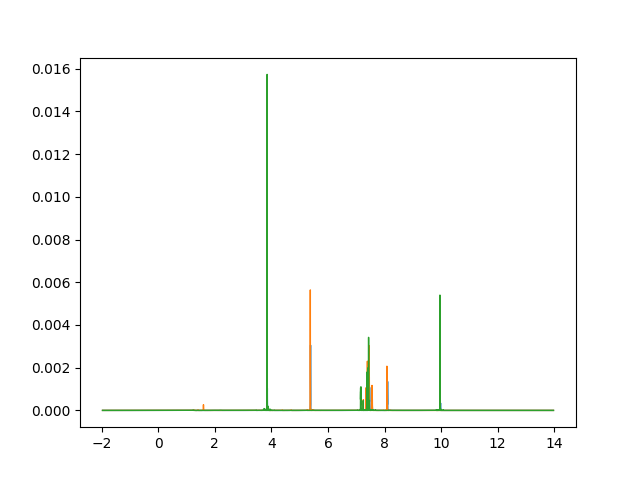

In [18]:
mix.plot(profile=True)
for sp in spectra:
    sp.plot(profile=True)

### Estimation with default kappas

In [19]:
default_MTD = 0.25
default_MTD_th = 0.22

In [20]:
start_vis = time.time()
estimation_vis = estimate_proportions(mix, spectra,
                                        MTD=default_MTD, 
                                        MTD_th=default_MTD_th,
                                        verbose=True, solver=pulp.GUROBI(msg=False), 
                                        what_to_compare='area')
stop_vis = time.time()

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2023-11-10
Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(-1.97165, 13.9718, 0), (-1.97165, 13.9718, 1)]
Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(-2.22165, 14.2218)]
Ion currents in chunks: [1.000000000000015]
Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 0.967176059127
Noise proportion in mixture's spectrum: 0.032823940889000064
Total explanation: 1.000000000016
Noise proportion in combination of components' spectra: 0.022267823378


In [21]:
estimation_vis['proportions']

[0.860212730006013, 0.10696332912100161]

In [22]:
estimation_vis['proportion_of_noise_in_components']

0.022267823378000335

In [23]:
1 - sum(estimation_vis['proportions'])

0.03282394087298546

In [24]:
print('Estimation took '+ str(stop_vis-start_vis) + ' seconds.')

Estimation took 129.59074449539185 seconds.


In [25]:
start_con = time.time()
estimation_molar = estimate_proportions(mix, spectra,
                                        MTD=default_MTD, 
                                        MTD_th=default_MTD_th,
                                        verbose=True, solver=pulp.GUROBI(msg=False), 
                                        what_to_compare='concentration')
stop_con = time.time()

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(-1.97165, 13.9718, 0), (-1.97165, 13.9718, 1)]
Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(-2.22165, 14.2218)]
Ion currents in chunks: [1.000000000000015]
Deconvolving chunk 0
Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 0.967176059127
Noise proportion in mixture's spectrum: 0.032823940889000064
Total explanation: 1.000000000016
Noise proportion in combination of components' spectra: 0.022267823378


In [26]:
estimation_molar

{'proportions': [0.8428023518973299, 0.15719764810267017],
 'Wasserstein distance': 0.026210663776070897}

In [27]:
print('Estimation took '+ str(stop_con-start_con) + ' seconds.')

Estimation took 127.38038301467896 seconds.


In [28]:
# #MTD = 0.25, MTD_th = 0.22

# #1: 'Pinene', 'Benzyl benzoate'
# 0.0937, 0.9063

# #2: 'Pinene', 'Limonene'
# 0.5240, 0.4760

# #3: 'Isopropyl myristate', 'Benzyl benzoate', 'Alpha pinene', 'Limonene'
# 0.7511, 0.1059, 0.0809, 0.0621

# #4: 'Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3165, 0.2137, 0.1341, 0.1960, 0.1397

# #5: 'Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3180, 0.2113, 0.1293, 0.2018, 0.1397

# #6: 'Pinene', 'Benzyl benzoate'
# 0.3931, 0.6069

# #7: 'Benzyl benzoate', 'm Anisaldehyde'
# 0.8428, 0.1572

# #8: 'Benzyl benzoate', 'm Anisaldehyde'
# 0.3762, 0.6238

# #9: Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride'
# 0.3180, 0.2125, 0.1333, 0.1967, 0.1395

# #10: 'Leucine', 'Isoleucine', 'Valine'
# # variant 1
# 0.3552, 0.3418, 0.3029

# #10: 'Leucine', 'Isoleucine', 'Valine'
# # variant 2
# 0.2793, 0.2173, 0.5034

# #10: 'Leucine', 'Isoleucine', 'Valine'
# # variant 3
# 0.2761, 0.4778, 0.2461

# #10: 'Leucine', 'Isoleucine', 'Valine'
# # variant 4
# 0.2494, 0.3357, 0.4149

# #11: 'Leucine', 'Isoleucine', 'Valine'
# 0.4960, 0.2519, 0.2521

#### Saving results of estimation with default parameters

In [29]:
res_vis = pd.DataFrame(np.array(estimation_vis['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_vis

,Benzyl benzoate,m Anisaldehyde
0,0.860213,0.106963


In [30]:
res_con = pd.DataFrame(np.array(estimation_molar['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_con

,Benzyl benzoate,m Anisaldehyde
0,0.842802,0.157198


In [31]:
# if (nr_of_experiment != 9 and nr_of_experiment != 4 and nr_of_experiment != 10):
#     res_vis.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area_default_parameters.csv')
# elif nr_of_experiment ==10:
#     res_vis.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area__default_parameters_variant_'+str(variant+1)+'.csv')
# else:
#     res_vis.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area__default_parameters_exp'+str(nr_of_experiment)+'.csv')

In [32]:
# if (nr_of_experiment != 9 and nr_of_experiment != 4 and nr_of_experiment != 10):
#     res_con.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration_default_parameters.csv')
# elif nr_of_experiment == 10:
#     res_con.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration_default_parameters_variant_'+str(variant+1)+'.csv')
# else:
#     res_con.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration_default_parameters_exp'+str(nr_of_experiment)+'.csv')

In [33]:
# comp_noise = np.array(estimation_vis['proportion_of_noise_in_components']).reshape(-1)
# if (nr_of_experiment != 9 and nr_of_experiment != 4 and nr_of_experiment != 10):
#     np.savetxt(experiments_folders['experiment_' + \
#                                     str(nr_of_experiment)] + \
#                                     '/proportion_of_noise_in_comp'+ \
#                                     '_default_parameters.csv',
#                                       comp_noise)
# elif nr_of_experiment == 10:
#     np.savetxt(experiments_folders['experiment_' + \
#                                     str(nr_of_experiment)] + \
#                                     '/proportion_of_noise_in_comp'+ \
#                                     '_variant' + str(variant+1) + \
#                                     '_default_parameters.csv',
#                                       comp_noise)
# else:
#     np.savetxt(experiments_folders['experiment_' + \
#                                     str(nr_of_experiment)] + \
#                                     '/proportion_of_noise_in_comp'+ \
#                                     '_exp' + str(nr_of_experiment) + \
#                                     '_default_parameters.csv',
#                                       comp_noise)

In [34]:
# mix_noise = np.array(1 - sum(estimation_vis['proportions'])).reshape(-1)
# if (nr_of_experiment != 9 and nr_of_experiment != 4 and nr_of_experiment != 10):
#     np.savetxt(experiments_folders['experiment_' + \
#                                     str(nr_of_experiment)] + \
#                                     '/proportion_of_noise_in_mix'+ \
#                                     '_default_parameters.csv',
#                                       mix_noise)
# elif nr_of_experiment == 10:
#     np.savetxt(experiments_folders['experiment_' + \
#                                     str(nr_of_experiment)] + \
#                                     '/proportion_of_noise_in_mix'+ \
#                                     '_variant' + str(variant+1) + \
#                                     '_default_parameters.csv',
#                                       mix_noise)
# else:
#     np.savetxt(experiments_folders['experiment_' + \
#                                     str(nr_of_experiment)] + \
#                                     '/proportion_of_noise_in_mix'+ \
#                                     '_exp' + str(nr_of_experiment) + \
#                                     '_default_parameters.csv',
#                                       mix_noise)

### Estimation with optimal kappas

In [35]:
start_vis_opt = time.time()
if nr_of_experiment != 10:
    estimation_vis_opt = estimate_proportions(mix, spectra,
                                            MTD=best_kappa_mix[nr_of_experiment-1],
                                            MTD_th=best_kappa_model[nr_of_experiment-1],
                                            verbose=True, solver=pulp.GUROBI(msg=False),
                                            what_to_compare='area')
else:
    estimation_vis_opt = estimate_proportions(mix, spectra,
                                            MTD=best_kappa_mix[nr_of_experiment-1][variant],
                                            MTD_th=best_kappa_model[nr_of_experiment-1][variant],
                                            verbose=True, solver=pulp.GUROBI(msg=False),
                                            what_to_compare='area')
stop_vis_opt = time.time()

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(-1.97165, 13.9718, 0), (-1.97165, 13.9718, 1)]
Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(-2.2716499999999997, 14.2718)]
Ion currents in chunks: [1.000000000000015]
Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 0.984332330358
Noise proportion in mixture's spectrum: 0.015667669591000095
Total explanation: 0.9999999999490001
Noise proportion in combination of components' spectra: 0.072954983833


In [36]:
print('Estimation took '+ str(stop_vis_opt-start_vis_opt) + ' seconds.')

Estimation took 146.52042150497437 seconds.


In [37]:
estimation_vis_opt['proportions']

[0.8753250370020133, 0.10900729335600165]

In [38]:
estimation_vis_opt['proportion_of_noise_in_components']

0.0729549838330011

In [39]:
start_con_opt = time.time()
if nr_of_experiment != 10:
    estimation_molar_opt = estimate_proportions(mix, spectra,
                                            MTD=best_kappa_mix[nr_of_experiment-1], 
                                            MTD_th=best_kappa_model[nr_of_experiment-1],
                                            verbose=True, solver=pulp.GUROBI(msg=False), 
                                            what_to_compare='concentration')
else:
    estimation_molar_opt = estimate_proportions(mix, spectra,
                                            MTD=best_kappa_mix[nr_of_experiment-1][variant], 
                                            MTD_th=best_kappa_model[nr_of_experiment-1][variant],
                                            verbose=True, solver=pulp.GUROBI(msg=False), 
                                            what_to_compare='concentration')
stop_con_opt = time.time()

Removed components' spectra due to no matching peaks in mixture's spectrum: []
Envelope bounds: [(-1.97165, 13.9718, 0), (-1.97165, 13.9718, 1)]
Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(-2.2716499999999997, 14.2718)]
Ion currents in chunks: [1.000000000000015]
Deconvolving chunk 0
Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 0.984332330358
Noise proportion in mixture's spectrum: 0.015667669591000095
Total explanation: 0.9999999999490001
Noise proportion in combination of components' spectra: 0.072954983833


In [40]:
print('Estimation took '+ str(stop_con_opt-start_con_opt) + ' seconds.')

Estimation took 148.43315267562866 seconds.


In [41]:
estimation_molar_opt['proportions']

[0.8426017738618099, 0.1573982261381901]

### Saving estimation results

In [42]:
res_vis_opt = pd.DataFrame(np.array(estimation_vis_opt['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_vis_opt

,Benzyl benzoate,m Anisaldehyde
0,0.875325,0.109007


In [43]:
res_con_opt = pd.DataFrame(np.array(estimation_molar_opt['proportions']).reshape(1,-1), 
             columns = components_dictionary['experiment_'+str(nr_of_experiment)])
res_con_opt

,Benzyl benzoate,m Anisaldehyde
0,0.842602,0.157398


In [44]:
# if (nr_of_experiment != 9 and nr_of_experiment != 4 and nr_of_experiment != 10):
#     res_vis_opt.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area.csv')
# elif nr_of_experiment == 10:
#     res_vis_opt.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area_variant'+str(variant+1)+'.csv')
# else:
#     res_vis_opt.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                    '/results_area_exp'+str(nr_of_experiment)+'.csv')

In [45]:
# if (nr_of_experiment != 9 and nr_of_experiment != 4 and nr_of_experiment != 10):
#     res_con_opt.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration.csv')
# elif nr_of_experiment == 10:
#     res_con_opt.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration_variant'+str(variant+1)+'.csv')
# else:
#     res_con_opt.to_csv(experiments_folders['experiment_' + str(nr_of_experiment)]+
#                '/results_concentration_exp'+str(nr_of_experiment)+'.csv')